# Проект "Прогноз оттока клиентов фитнес-центров «Культурист-датасаентист»"

Цель проекта - анализ данных с целью разработки стратегии по удержанию клиентов.

## Загрузка данных

Импортируем все библиотеки.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

import warnings 
warnings.filterwarnings("ignore")

Загрузим наш датасет и посмотрим на него.

In [2]:
data = pd.read_csv('gym_churn.csv')

In [3]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


Приведём названия столбцов к нижнему регистру для удобства.

In [4]:
data.columns = data.columns.str.lower()
data

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,1,1,1,0,1,12,0,33,2.406023,12.0,8,2.284497,2.349070,0
3996,0,1,0,0,1,1,1,29,68.883764,1.0,1,1.277168,0.292859,1
3997,1,1,1,1,1,12,0,28,78.250542,11.0,2,2.786146,2.831439,0
3998,0,1,1,1,1,6,0,32,61.912657,5.0,3,1.630108,1.596237,0


Проверим наличие дубликатов.

In [5]:
data.duplicated().sum()

0

У нас нет дубликатов. Переходим к следующему шагу.

## Исследовательский анализ данных (EDA)

### Посмотрим на датасет на предмет отсутствующих признаков. Изучим средние значения и стандартные отклонения

Воспользуемся describe. Для удобства чтения транспортируем массив, применив .T, т.е. поменяем местами строки и столбцы.

In [6]:
data.describe().T.style.background_gradient('coolwarm')

,count,mean,std,min,25%,50%,75%,max
gender,4000.000000,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
near_location,4000.000000,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
partner,4000.000000,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
promo_friends,4000.000000,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
phone,4000.000000,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,4000.000000,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
group_visits,4000.000000,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
age,4000.000000,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
avg_additional_charges_total,4000.000000,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
month_to_end_contract,4000.000000,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


Получанные данные говорят о следующем:
- Разделение клиентов по признаку пола примерно равное;
- Почти 85% клиентов проживают или работают рядом с фитнес-центром;
- Чуть меньше половины всех клиентов являются сотрудниками компании-партнёра клуба;
- 30% клиентов пришли по промокоду от клиента клуба ("приведи друга");
- Контактный номер не указан у 10% клиентов;
- В среднем клиент ходит в фитнес-центр 4,6 месяцев;
- 40% клиентов посещяют групповые занятия;
- Средний возраст клиентов - 29 лет;
- Средняя суммарная выручка от прочих услуг фитнес-центра составляет почти 147 000 у.е.;
- Средний срок до окончания контрактов составляет 4,3 месяца;
- Среднее время посещения клиента с первого обращения составляет 3,7 месяцев;
- Средняя частота посещений в неделю за все время с начала действия абонемента составляет 2 раза;
- Средняя частота посещений в неделю за предыдущий месяц также составляет 2 раза;
- Отток клиентов составляет 26% - много!

### Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался

Сгруппируем датасет по признаку churn с использованием метода .T.

In [7]:
data.groupby('churn').mean().T.style.background_gradient('coolwarm')

churn,0,1
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
month_to_end_contract,5.283089,1.662582


По факту оттока пользователей можно сделать следующие выводы:
- С т.з. пола разницы в оттоке нет;
- Оттока меньше среди тех, кто живёт или работает неподалёку от фитнес-центра;
- Также оттока меньше среди сотрудников компании-партнёра клуба;
- Среди участников акции "приведи друга" отток в 2 раза меньше;
- С т.з. наличия контактного телефона разницы в группах нет;
- В группе тех, кто остался, длительность абонемента в среднем составляет полгода, в то время как у тех, кто ушёл в отток - 1 месяц;
- Те, кто остался, в 2 раза чаще посещают групповые занятия, нежели те, кто ушёл;
- Средний возраст тех, кто остался - 29 лет. Тех, кто ушёл - 26 лет;
- Суммарная выручка от других услуг фитнес-центра в группе оттока на 43 у.е. меньше, чем в группе оставшихся;
- Срок до окончания текущего действующего абонемента в группе тех, кто остаётся - 5 месяцев, а в группе тех, кто ушёл - 1-2 месяца;
- Среднее время посещения клиента с первого обращения в группе оттока составляет 1 месяц, в группе оставшихся - 5 месяцев;
- Средняя частота посещений в неделю за все время с начала действия абонемента в группе оттока - 1 раз, в группе оставшихся - 2 раза;
- Средняя частота посещений в неделю за предыдущий месяц также составляет 1 раз у группы оттока и 2 раза у группы тех, кто остался.

### Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток)

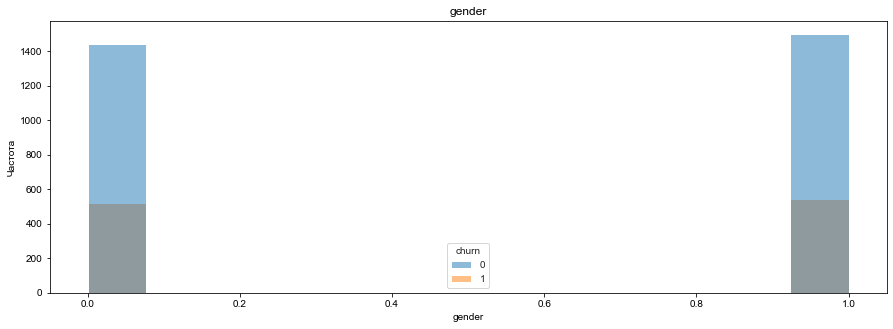

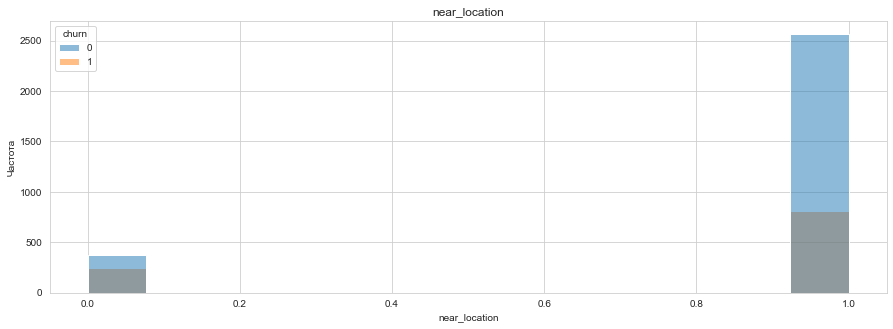

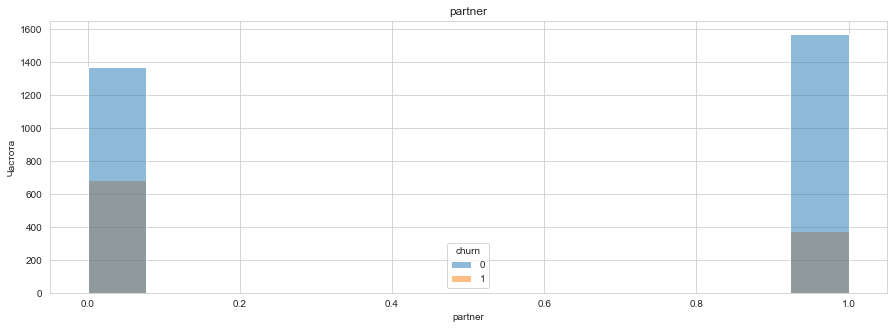

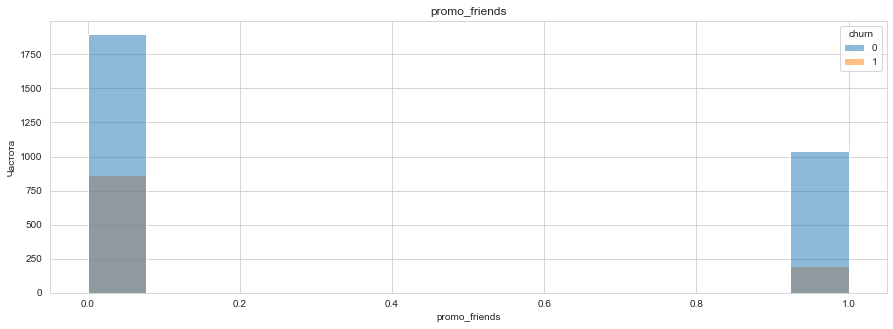

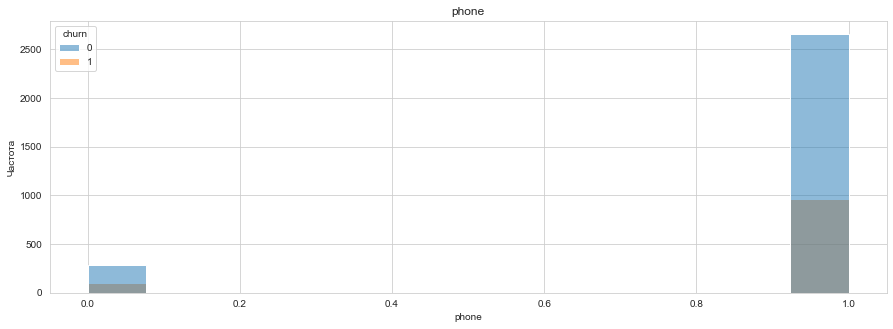

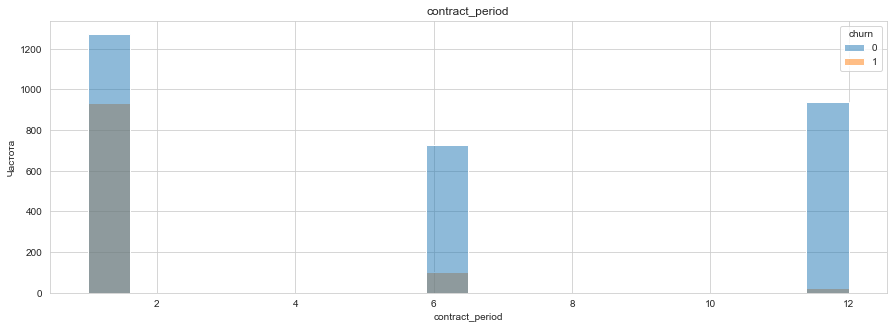

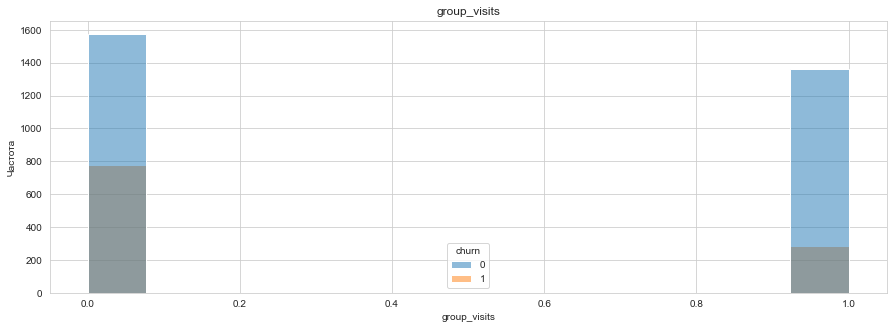

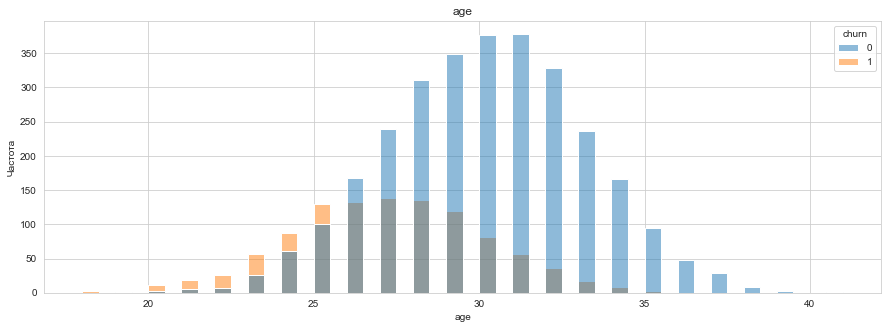

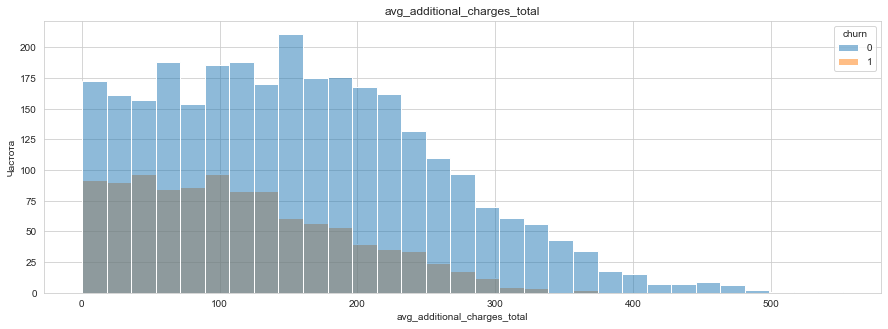

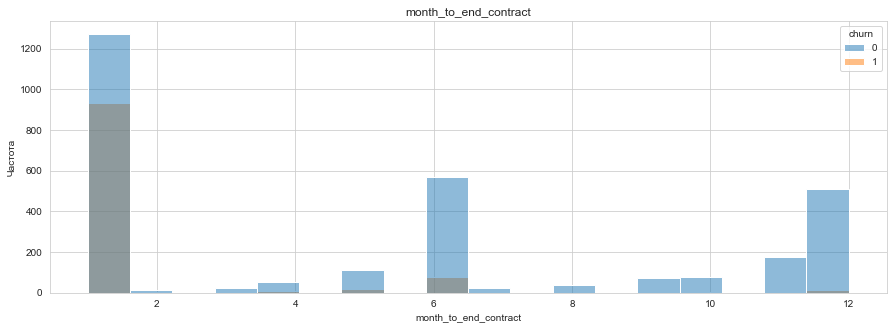

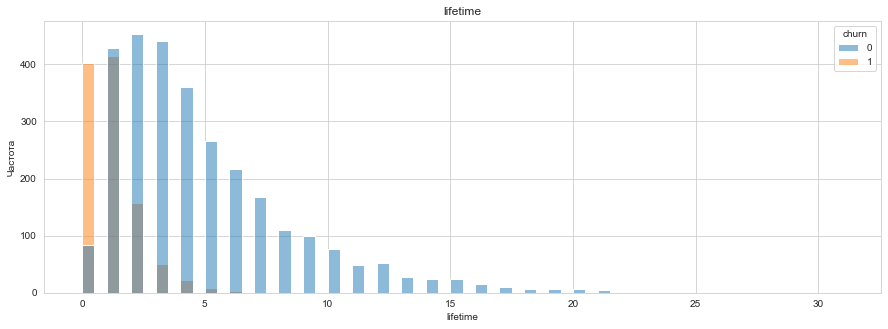

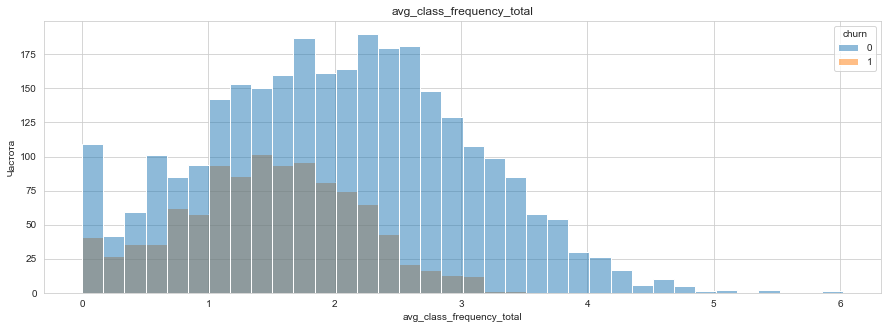

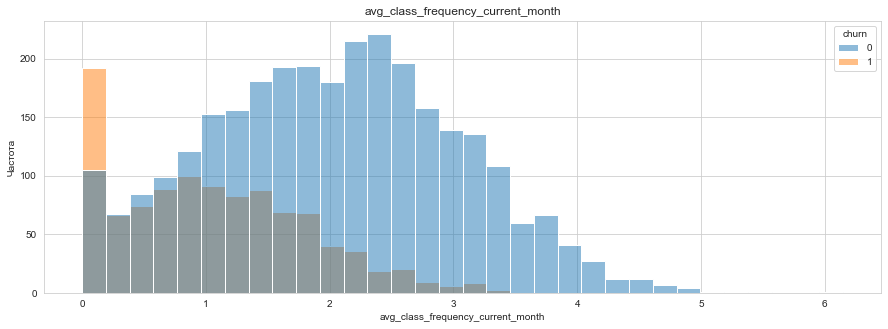

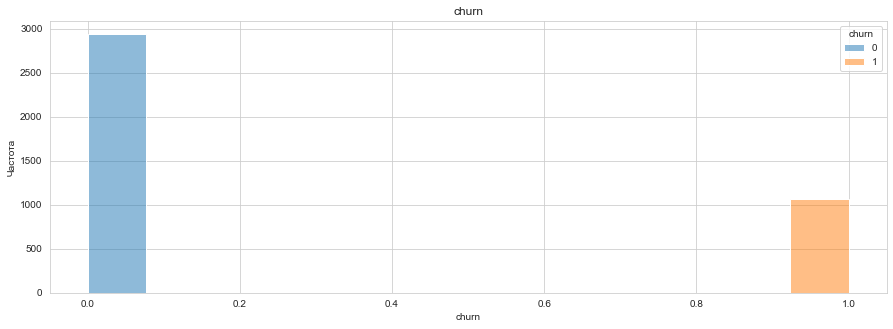

In [8]:
for col in data.columns:
    plt.figure(figsize=(15,5))
    plt.title(col)
    sns.set_style("whitegrid")
    sns.histplot(data, x=col, hue='churn', alpha=0.5)
    plt.xlabel(col)
    plt.ylabel('Частота')
    plt.show()

Какое-либо комментирование излишне, поскольку основные выводы уже написаны в предыдущем пункте.

### Построим матрицу корреляций

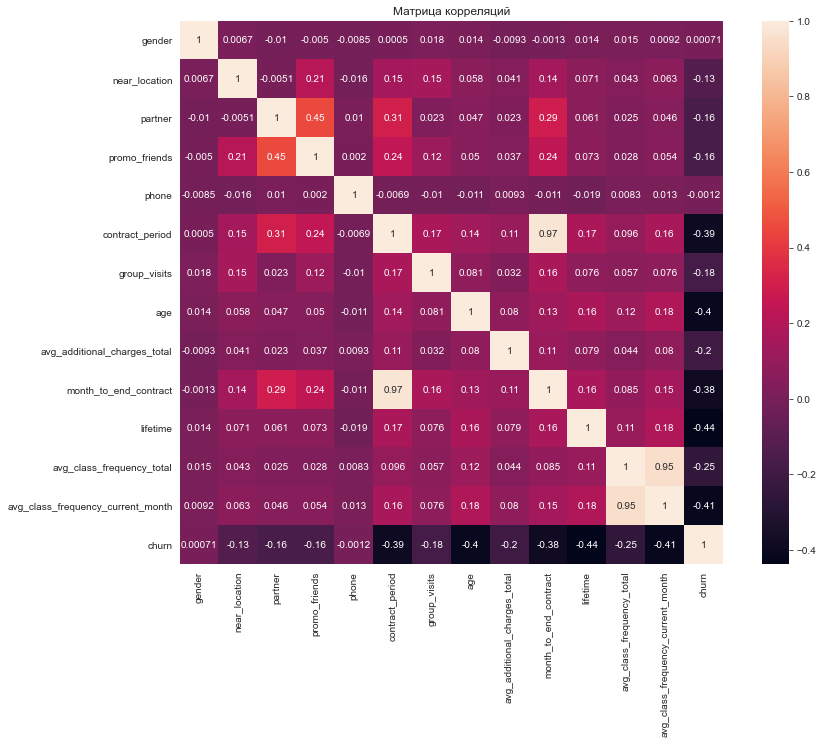

In [9]:
plt.figure(figsize=(14,10))
sns.heatmap(data = data.corr(), annot=True, square=True)
plt.title('Матрица корреляций')
plt.show()

Имеются значимые корреляции между month_to_end_contract и contract_period, а также Avg_class_frequency_total и Avg_class_frequency_current_month, однако эта корреляция ничем нам не поможет. В остальных случаях значимая корреляция не наблюдается.

## Построим модель прогнозирования оттока клиентов

### Разобьём данные на обучающую и валидационную выборку функцией train_test_split()

In [10]:
X = data.drop(['churn'], axis = 1)
y = data['churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Обучим модель на train-выборке двумя способами:
#### Логистической регрессией

In [11]:
lr_model = LogisticRegression(random_state=0, solver = 'liblinear')
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_test)
lr_probabilities = lr_model.predict_proba(X_test)[:,1]
print('accuracy_score: {}\nprecision_score: {}\nrecall_score: {}'.format(
    accuracy_score(y_test, lr_predictions),
    precision_score(y_test, lr_predictions),
    recall_score(y_test, lr_predictions)
))

accuracy_score: 0.925
precision_score: 0.8631578947368421
recall_score: 0.8282828282828283


#### Случайным лесом

In [12]:
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0) 
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
rf_probabilities = rf_model.predict_proba(X_test)[:,1]
print('accuracy_score: {}\nprecision_score: {}\nrecall_score:{}'.format(
    accuracy_score(y_test, rf_predictions),
    precision_score(y_test, rf_predictions),
    recall_score(y_test, rf_predictions)
))

accuracy_score: 0.91625
precision_score: 0.8393782383419689
recall_score:0.8181818181818182


Результат показал, что логистическая регрессия дала более высокую долю правильных прогнозов. Следовательно, её использование представляется более целесообразным.

### Оценим метрики accuracy, precision и recall для обеих моделей на валидационной выборке и сравним по ним модели

In [13]:
features = pd.DataFrame(lr_model.coef_.T, X.columns).reset_index()
features.columns = ['feature', 'coef']
features['coef'] = features['coef'].apply(lambda x: abs(x))
features = features.sort_values(by='coef', ascending=False)
print(features)

                              feature      coef
12  avg_class_frequency_current_month  4.162484
11          avg_class_frequency_total  3.471382
10                           lifetime  0.972882
6                        group_visits  0.712873
4                               phone  0.611626
3                       promo_friends  0.568360
5                     contract_period  0.188791
7                                 age  0.181938
9               month_to_end_contract  0.067131
1                       near_location  0.052936
2                             partner  0.048518
0                              gender  0.048117
8        avg_additional_charges_total  0.004675


**avg_class_frequency_current_month** и **avg_class_frequency_current_month** являются наиболее значимыми признаками по весам.

## Сделаем кластеризацию клиентов


### Стандартизируем данные

In [14]:
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)

### Построим матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуем дендрограмму

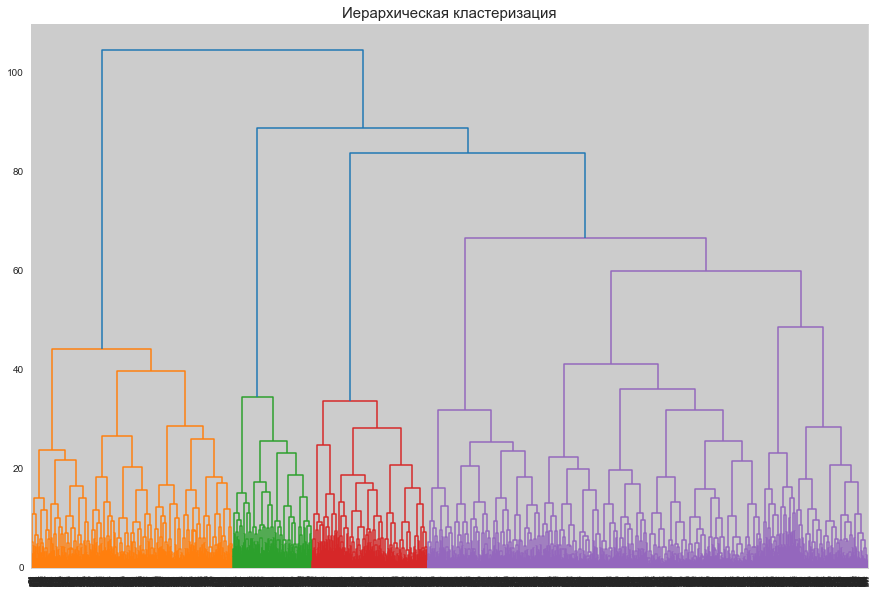

In [15]:
X_st = scaler.fit_transform(X)
linked = linkage(X_st, method='ward')
plt.figure(figsize=(15, 10))
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация', fontsize=15)
plt.show()

На основании полученного графика можно выделить 4 неравномерных кластера.

### Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов

Несмотря на то, что дендрограмма показала 4 кластера, в этом пункте зададим 5 кластеров, т.к. так написано в ТЗ.

In [16]:
km = KMeans(n_clusters = 5, random_state = 0)
labels = km.fit_predict(X_st)
data['cluster_km'] = labels

### Посмотрим на средние значения признаков для кластеров

In [17]:
data.groupby('cluster_km').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
cluster_km,,,,,,,,,,,,,,
0,0.502970,0.959406,0.783168,0.574257,1.000000,10.889109,0.542574,29.982178,160.761016,9.954455,4.736634,1.982055,1.974789,0.027723
1,0.522078,0.862338,0.470130,0.306494,0.000000,4.787013,0.425974,29.301299,143.957664,4.475325,3.924675,1.847220,1.716369,0.267532
2,0.495050,0.000000,0.463366,0.079208,1.000000,2.352475,0.215842,28.477228,135.457501,2.198020,2.809901,1.660461,1.477324,0.443564
3,0.485737,1.000000,0.350238,0.240095,1.000000,1.948494,0.341521,28.167987,131.622204,1.856577,2.440571,1.247634,1.012983,0.514263
4,0.559666,0.976134,0.356802,0.230310,0.998807,2.669451,0.473747,30.125298,161.657905,2.459427,4.898568,2.852002,2.850161,0.068019


Средние значения показывают следующие результаты:
- Значения по признаку пола приблизительно одинаковые;
- Клиенты кластера 2 живут далеко от фитнес-клуба, остальные - более-менее близко;
- Самый высокий средний показатель сотрудников компании-партнёра клуба в кластере 0 - он составляет 78%.
- Наиболее высока доля по акции "приведи друга" в кластере 0.
- В кластере 1 не указаны контактные телефонные номера.
- Клиенты из кластер 0 заключают самые договора на самый длинные период - год;
- Самая высокая доля посещающих групповые занятия снова в кластере 0 - их там 54%;
- Средний возраст примерно везде одинаковый - от 28 до 20 лет;
- Суммарная выручка от прочих услуг фитнес-центра в кластерах 0 и 4 ощутимо выше, чем в других кластерах;
- Срок до окончания текущего действующего абонемента наиболее высок в кластере 0 - он составляет почти 10 месяцев;
- Средний срок жизни наиболее высок в кластерах 4 и 0;
- Средняя частота посещений в неделю за все время с начала действия абонемента, а равно и за предыдущий месяц у 4 кластера.

### Построим распределения признаков для кластеров

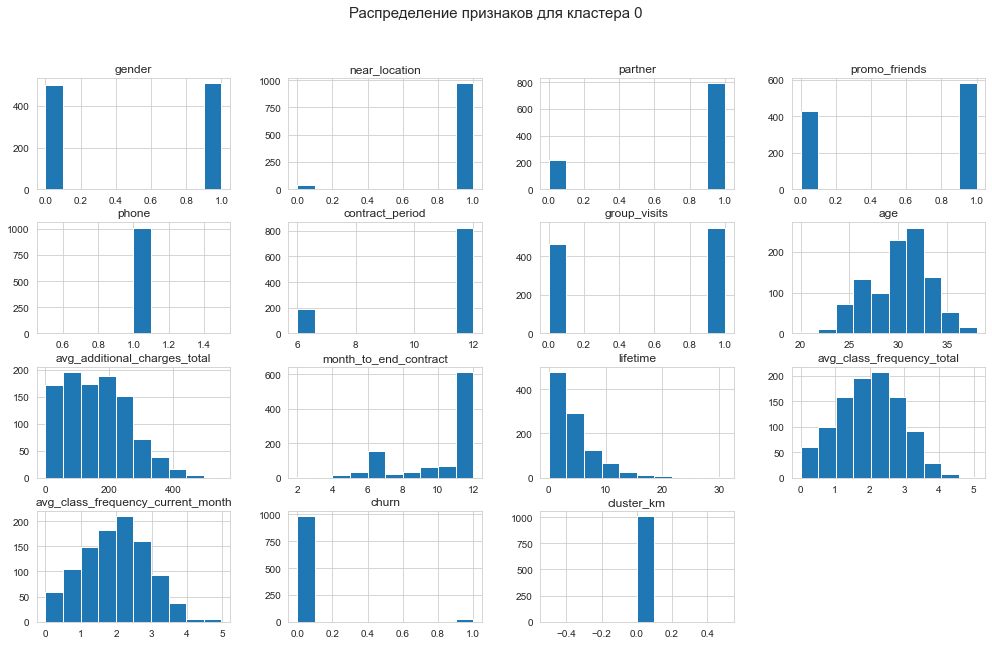

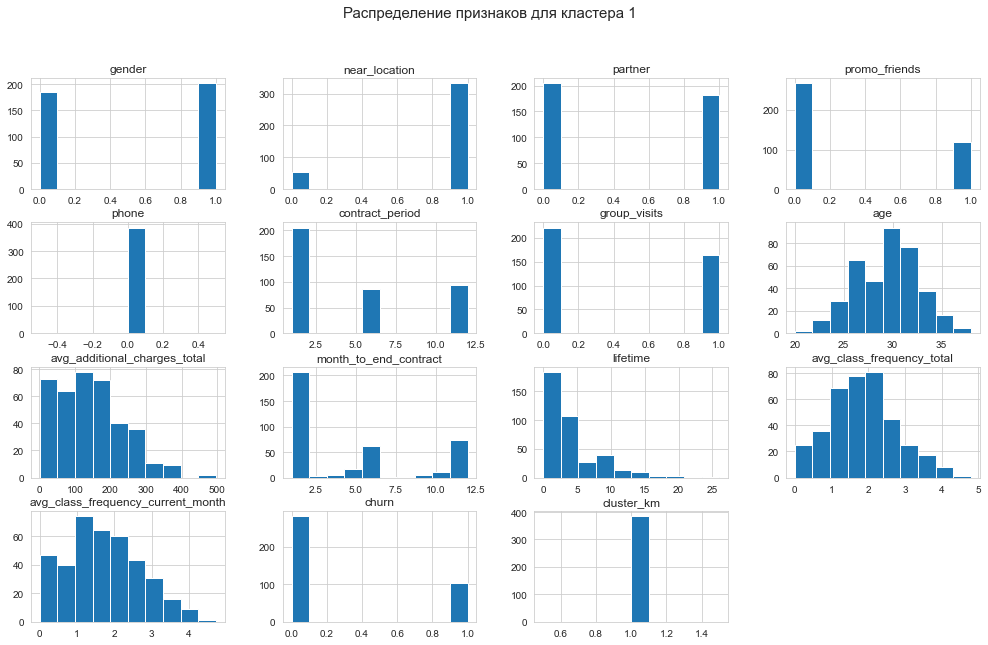

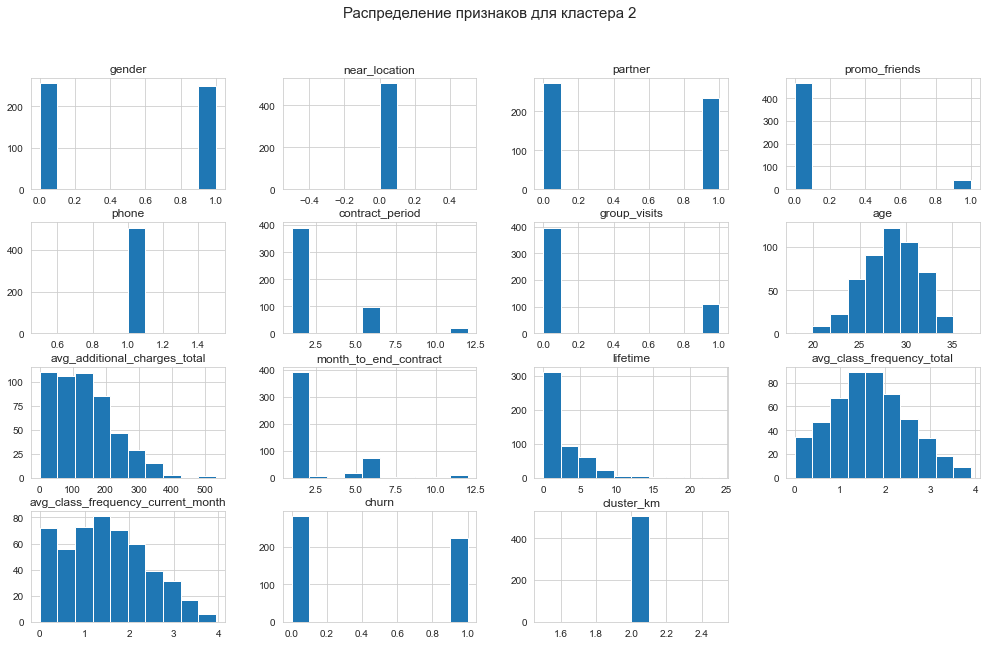

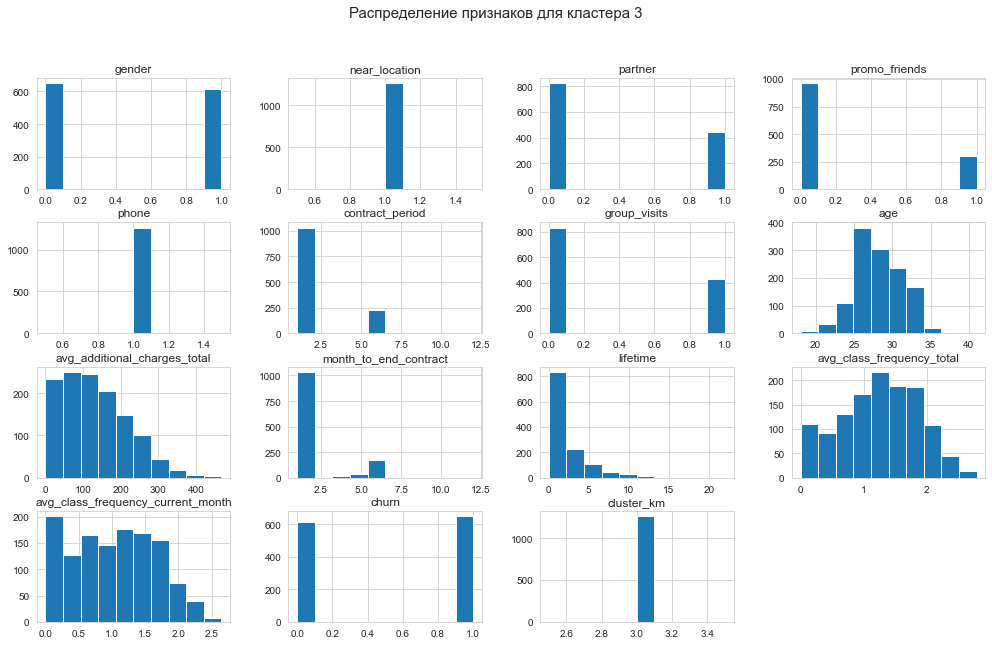

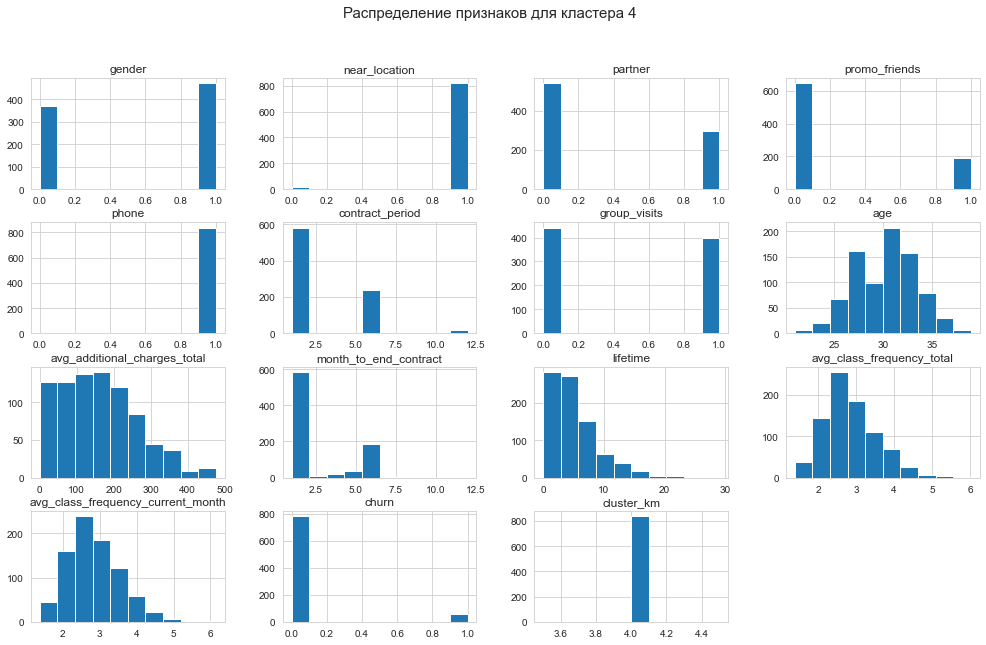

In [18]:
for value in [0, 1, 2, 3, 4]:
    data[data['cluster_km']==value].hist(figsize=(17,10))
    plt.suptitle('Распределение признаков для кластера {}'.format(value), fontsize = 15)
    plt.show()

### Для каждого полученного кластера посчитаем долю оттока (методом groupby())

In [19]:
data_per = data.groupby('cluster_km')['churn'].mean().reset_index() 
data_per['churn'] * 100

0     2.772277
1    26.753247
2    44.356436
3    51.426307
4     6.801909
Name: churn, dtype: float64

Наиболее высокая доля оттока в кластере 3 - там она составляет 51%. На втором месте кластер 2 - у него 44%. Третье место с 26% занимает кластер 1. Четвёртое место у кластера 4 - здесь отток составляет 6%. Последнее место по оттоку у кластера 0 - здесь отток составляет всего 2%.

## Выводы и базовые рекомендации по работе с клиентами

Перед нами была поставлена цель проанализировать данные по поведению клиентов фитнес-клуба, чтобы разработать стратегию по удержанию клиентов. Мы изучили данные и выяснили следующее: 

- Разделение клиентов по признаку пола примерно равное;
- Почти 85% клиентов проживают или работают рядом с фитнес-центром;
- Чуть меньше половины всех клиентов являются сотрудниками компании-партнёра клуба;
- 30% клиентов пришли по промокоду от клиента клуба ("приведи друга");
- Контактный номер не указан у 10% клиентов;
- В среднем клиент ходит в фитнес-центр 4,6 месяцев;
- 40% клиентов посещяют групповые занятия;
- Средний возраст клиентов - 29 лет;
- Средняя суммарная выручка от прочих услуг фитнес-центра составляет почти 147 000 у.е.;
- Средний срок до окончания контрактов составляет 4,3 месяца;
- Среднее время посещения клиента с первого обращения составляет 3,7 месяцев;
- Средняя частота посещений в неделю за все время с начала действия абонемента составляет 2 раза;
- Средняя частота посещений в неделю за предыдущий месяц также составляет 2 раза;
- Отток клиентов составляет 26% - много!

Затем мы проанализировали данные по факту оттока, разделив пользователей на две группы: тех, кто ушёл, и тех, кто остался. Полученные данные говорят о следующем:
- С т.з. пола разницы в оттоке нет;
- Оттока меньше среди тех, кто живёт или работает неподалёку от фитнес-центра;
- Также оттока меньше среди сотрудников компании-партнёра клуба;
- Среди участников акции "приведи друга" отток в 2 раза меньше;
- С т.з. наличия контактного телефона разницы в группах нет;
- В группе тех, кто остался, длительность абонемента в среднем составляет полгода, в то время как у тех, кто ушёл в отток - 1 месяц;
- Те, кто остался, в 2 раза чаще посещают групповые занятия, нежели те, кто ушёл;
- Средний возраст тех, кто остался - 29 лет. Тех, кто ушёл - 26 лет;
- Суммарная выручка от других услуг фитнес-центра в группе оттока на 43 у.е. меньше, чем в группе оставшихся;
- Срок до окончания текущего действующего абонемента в группе тех, кто остаётся - 5 месяцев, а в группе тех, кто ушёл - 1-2 месяца;
- Среднее время посещения клиента с первого обращения в группе оттока составляет 1 месяц, в группе оставшихся - 5 месяцев;
- Средняя частота посещений в неделю за все время с начала действия абонемента в группе оттока - 1 раз, в группе оставшихся - 2 раза;
- Средняя частота посещений в неделю за предыдущий месяц также составляет 1 раз у группы оттока и 2 раза у группы тех, кто остался.

По каждому из пунктов мы построили графики.

Мы также выяснили, что значимой корреляции между признаками не наблюдается.

Затем мы построили модель прогнозирования оттока клиентов и выяснили, что логистическая регрессия дала более высокую долю правильных прогнозов. Следовательно, её использование представляется более целесообразным.

Наиболее значимыми признаками по весам являюся признаки avg_class_frequency_current_month и avg_class_frequency_current_month.

Затем мы построили дендрограмму, на основании которой выделили 4 кластера. Тем не менее, далее мы использовали 5 кластеров, поскольку там было сказано в ТЗ. Мы детально изучили средние значения признаков для кластеров, которые говорят о следующем:

- Значения по признаку пола приблизительно одинаковые;
- Клиенты кластера 2 живут далеко от фитнес-клуба, остальные - более-менее близко;
- Самый высокий средний показатель сотрудников компании-партнёра клуба в кластере 0 - он составляет 78%;
- Наиболее высока доля по акции "приведи друга" в кластере 0;
- В кластере 1 не указаны контактные телефонные номера;
- Клиенты из кластера 0 заключают договора на самый длинный период - год;
- Самая высокая доля посещающих групповые занятия снова в кластере 0 - их там 54%;
- Средний возраст примерно везде одинаковый - от 28 до 20 лет;
- Суммарная выручка от прочих услуг фитнес-центра в кластерах 0 и 4 ощутимо выше, чем в других кластерах;
- Срок до окончания текущего действующего абонемента наиболее высок в кластере 0 - он составляет почти 10 месяцев;
- Средний срок жизни наиболее высок в кластерах 4 и 0;
- Средняя частота посещений в неделю за все время с начала действия абонемента, а равно и за предыдущий месяц у 4 кластера.

Наиболее высокая доля оттока в кластере 3 - там она составляет 51%. На втором месте кластер 2 - у него 44%. Третье место с 26% занимает кластер 1. Четвёртое место у кластера 4 - здесь отток составляет 6%. Последнее место по оттоку у кластера 0 - здесь отток составляет всего 2%.

Поскольку наименьший отток у обладаетелей самых длительных по сроку действия договоров, рекомендуется **выстраивать маркетинговую стратегию таким образом, чтобы мотивировать покупателей покупать именно долгосрочные абонементы**.

Равным образом рекомендуется мотивировать клиентов посещать **групповые занятия** (по собственному опыту могу сказать, что на групповых занятиях завязываются неформальные связи, которые мотивируют приходить и далее), посещать фитнес-клуб **не реже 2 раз в неделю** (апелляция к эффективности частых занятий), более внимательное отношение к **промо-акциям** и **программам с компаниями-партнёрами**.

Таковы, на наш взгляд, основные рекомендации.